In [256]:
#Week 1 - Data Cleaning, EDA, Scaling
#Project 2: Customer Segmentation using K-Means (Week 1)
#Goal: Segment customers based on shopping behavior & demographics to help create targeted marketing strategies.
#This week, we will collect, clean, analyze, and preprocess data so it is ready for clustering in Week 2.

In [257]:
# Install and import libraries
!pip -q install pandas numpy matplotlib seaborn scikit-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [258]:
df = pd.read_csv(r"C:\Users\rimjh\Downloads\Customer Segmentaion using K-Means.zip", on_bad_lines='skip')

print("Shape:", df.shape)
df.head()

Shape: (99457, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [259]:
# Load dataset, skipping any bad lines
df = pd.read_csv(r"C:\Users\rimjh\Downloads\Customer Segmentaion using K-Means.zip", on_bad_lines='skip')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()


✅ Dataset loaded successfully!
Shape: (99457, 10)

First 5 rows:


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [260]:
# Info about dataset
df.info()

# Column names
print("Columns:", list(df.columns))

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB
Columns: ['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price', 'payment_method', 'invoice_date', 'shopping_mall']

Missing values per column:
invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
p

In [261]:
dup_count = df.duplicated().sum()
print("Duplicate rows before:", dup_count)

# Remove duplicates
df = df.drop_duplicates()

print("Duplicate rows after:", df.duplicated().sum())


Duplicate rows before: 0
Duplicate rows after: 0


In [262]:
# Convert dates
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True, errors='coerce')

# Drop rows with missing key values
key_cols = ['customer_id','age','gender','quantity','price','invoice_date']
df = df.dropna(subset=key_cols)

# Convert to numeric
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['price']    = pd.to_numeric(df['price'], errors='coerce')
df['age']      = pd.to_numeric(df['age'], errors='coerce')

# Remove invalid values
df = df[(df['quantity'] > 0) & (df['price'] > 0)]
df = df[(df['age'] >= 10) & (df['age'] <= 100)]

print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (99457, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon


In [263]:
# Add spend column
df['line_amount'] = df['price'] * df['quantity']

# Aggregate by customer
cust = (df.groupby('customer_id')
          .agg(gender=('gender','first'),
               age=('age','median'),
               total_spend=('line_amount','sum'),
               total_quantity=('quantity','sum'),
               unique_categories=('category','nunique'),
               unique_malls=('shopping_mall','nunique'),
               first_purchase=('invoice_date','min'),
               last_purchase=('invoice_date','max'),
               num_invoices=('invoice_no','nunique'))
          .reset_index())

# Add recency
ref_date = df['invoice_date'].max()
cust['recency_days'] = (ref_date - cust['last_purchase']).dt.days

cust.head()

,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591


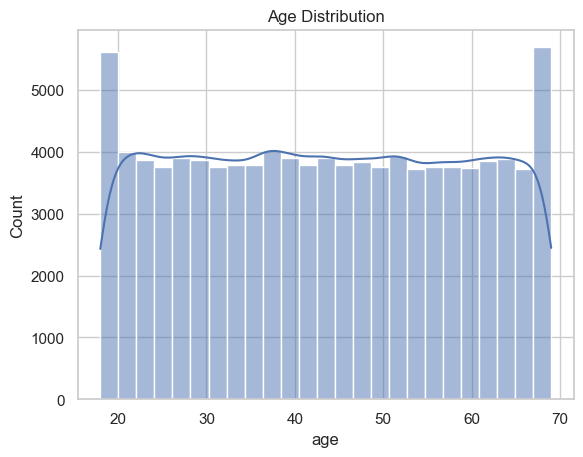

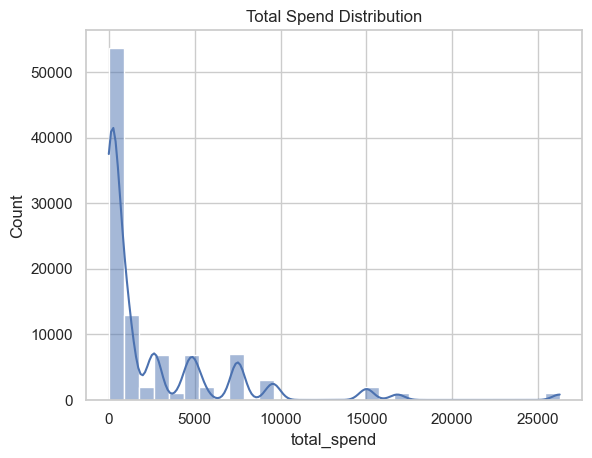

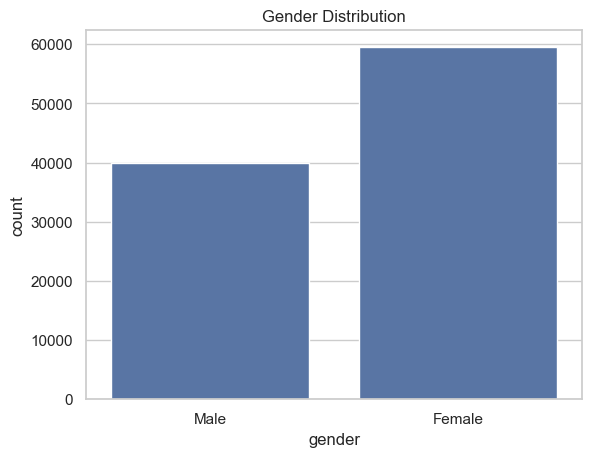

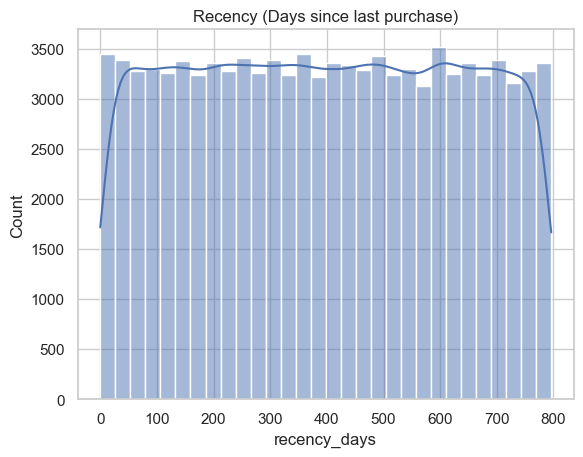

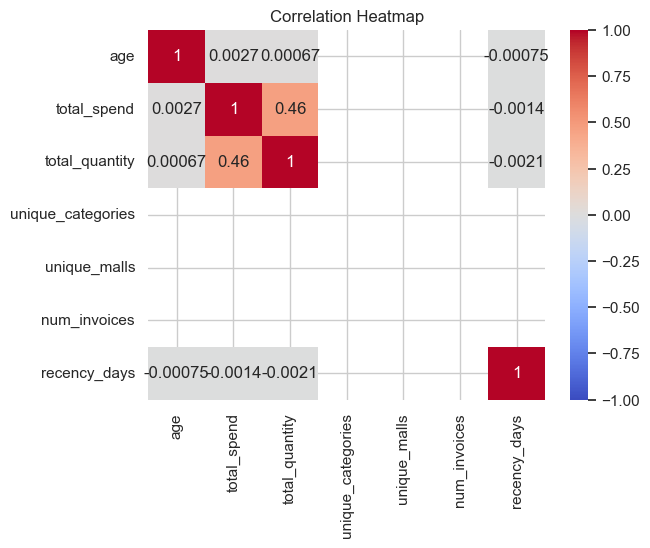

In [264]:
# Age distribution
sns.histplot(cust['age'], bins=25, kde=True)
plt.title("Age Distribution")
plt.show()

# Spend distribution
sns.histplot(cust['total_spend'], bins=30, kde=True)
plt.title("Total Spend Distribution")
plt.show()

# Gender distribution
sns.countplot(x='gender', data=cust)
plt.title("Gender Distribution")
plt.show()

# Recency
sns.histplot(cust['recency_days'], bins=30, kde=True)
plt.title("Recency (Days since last purchase)")
plt.show()

# Correlation heatmap
num_cols = ['age','total_spend','total_quantity','unique_categories',
            'unique_malls','num_invoices','recency_days']
sns.heatmap(cust[num_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


In [265]:
features = ['age','total_spend','total_quantity',
            'unique_categories','unique_malls',
            'num_invoices','recency_days']

X = cust[features].copy()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save outputs
np.save("X_scaled.npy", X_scaled)
cust.to_csv("customer_level_week1.csv", index=False)
joblib.dump(scaler, "scaler.pkl")

print("Scaling complete. Files saved:")
print("- customer_level_week1.csv")
print("- X_scaled.npy")
print("- scaler.pkl")


Scaling complete. Files saved:
- customer_level_week1.csv
- X_scaled.npy
- scaler.pkl


In [266]:
#Week 2: K-Means Clustering
#In this week, we will:

#Apply K-Means clustering on the scaled dataset.
#Determine the optimal number of clusters using:
#Elbow Method (Inertia vs. K)
#Silhouette Score (Cluster quality)
#Visualize clusters using PCA (2D scatter plot).
#Save clus

In [267]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load customer-level dataset and scaled features
cust = pd.read_csv("customer_level_week1.csv")
X_scaled = np.load("X_scaled.npy")

print("✅ Data loaded for clustering")
print("Customer dataset shape:", cust.shape)


✅ Data loaded for clustering
Customer dataset shape: (99457, 11)


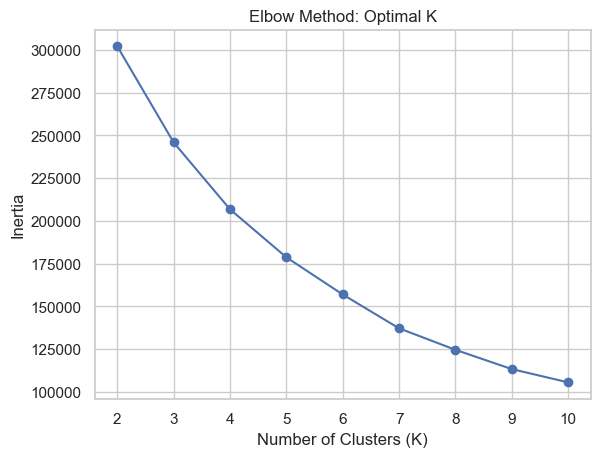

Silhouette Scores (on 5,000 sample): {2: 0.24336666337897406, 3: 0.23606642301920683, 4: 0.23237105982377676, 5: 0.2431348584883219, 6: 0.25034212294267116, 7: 0.2616847063894927, 8: 0.2534233359331849, 9: 0.2532017887725134, 10: 0.252273730332075}


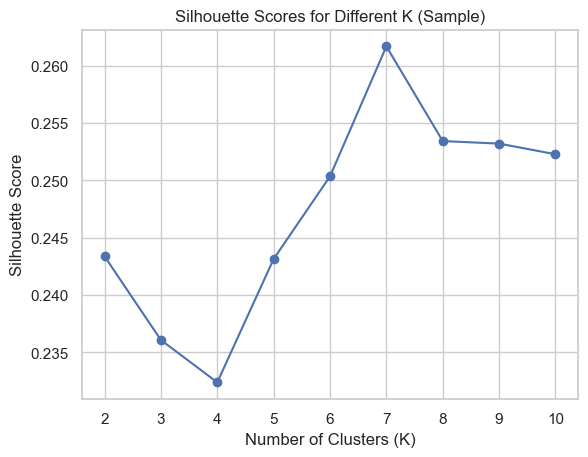

In [268]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

K_range = range(2, 11)

# ---- Elbow Method (use full dataset) ----
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method: Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

# ---- Silhouette Score (use sample for speed) ----
X_sample = resample(X_scaled, n_samples=5000, random_state=42)  # random 5k customers

sil_scores = {}
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    sil_scores[k] = sil

print("Silhouette Scores (on 5,000 sample):", sil_scores)

plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Scores for Different K (Sample)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [269]:
# Choose K (adjust based on Elbow/Silhouette results)
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cust['cluster'] = kmeans_final.fit_predict(X_scaled)

# Save model & clustered dataset
joblib.dump(kmeans_final, "kmeans_model.pkl")
cust.to_csv("customer_clusters_week2.csv", index=False)

print("✅ Final K-Means trained with K =", optimal_k)
cust[['customer_id','cluster']].head()


✅ Final K-Means trained with K = 4


,customer_id,cluster
0,C100004,2
1,C100005,3
2,C100006,3
3,C100012,0
4,C100019,0


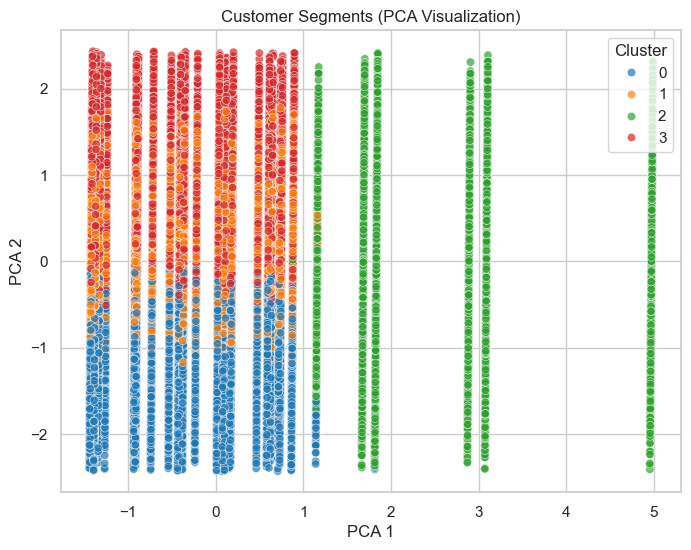

In [270]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=cust['cluster'], palette="tab10", alpha=0.7)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

In [271]:
#Week 3: Cluster Profiling & Marketing Insights
#Now that we have segmented customers into clusters using K-Means,
#our goal this week is to profile each cluster and extract actionable insights.

#We will:

#Summarize each cluster by average spending, quantity, recency, demographics
#Visualize clusters with charts (spend, age, recency, etc.)
#Generate marketing strategy recommendations for each cluster.
#This helps translate the clustering results into real business value.

In [272]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load customer dataset with clusters from Week 2
cust = pd.read_csv("customer_clusters_week2.csv")

print("✅ Clustered dataset loaded")
print(cust['cluster'].value_counts())
cust.head()

✅ Clustered dataset loaded
cluster
3    32253
0    26925
1    26323
2    13956
Name: count, dtype: int64


,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days,cluster
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467,2
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5,3
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97,3
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570,0
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591,0


In [273]:
# Compute cluster summary
cluster_summary = cust.groupby('cluster').agg({
    'age':'mean',
    'total_spend':'mean',
    'total_quantity':'mean',
    'unique_categories':'mean',
    'unique_malls':'mean',
    'num_invoices':'mean',
    'recency_days':'mean'
}).round(1)

cluster_summary

,age,total_spend,total_quantity,unique_categories,unique_malls,num_invoices,recency_days
cluster,,,,,,,
0,29.5,1168.9,2.7,1.0,1.0,1.0,543.1
1,57.5,1153.5,2.7,1.0,1.0,1.0,544.7
2,43.5,11006.3,4.6,1.0,1.0,1.0,392.6
3,43.5,1118.2,2.7,1.0,1.0,1.0,156.0


C:\Users\rimjh\AppData\Local\Temp\ipykernel_8036\2590853632.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)


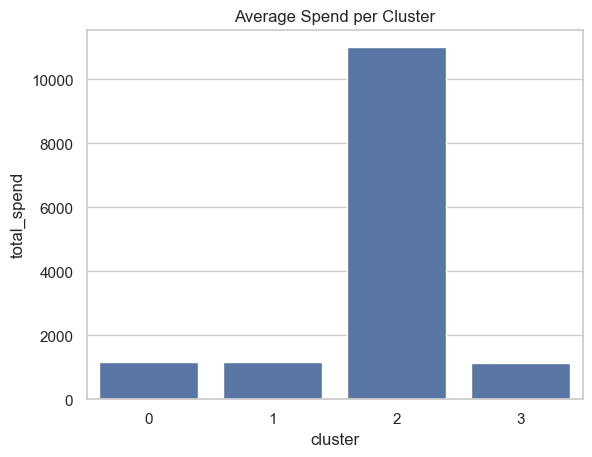

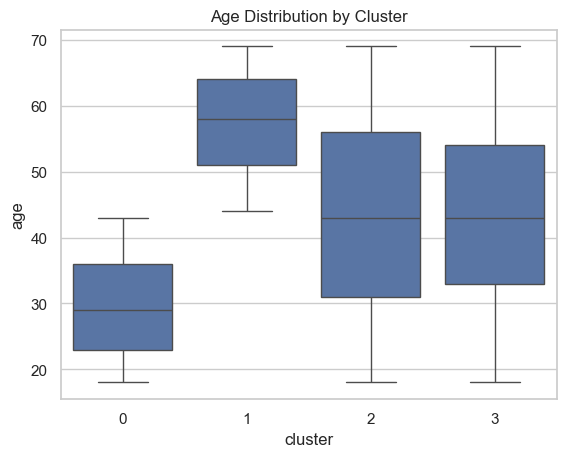

C:\Users\rimjh\AppData\Local\Temp\ipykernel_8036\2590853632.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='recency_days', data=cust, estimator='mean', ci=None)


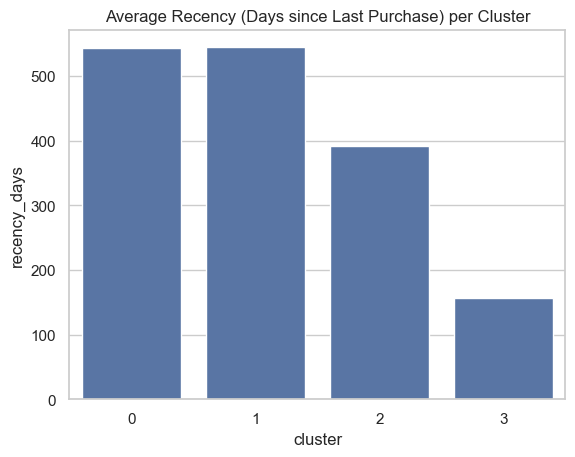

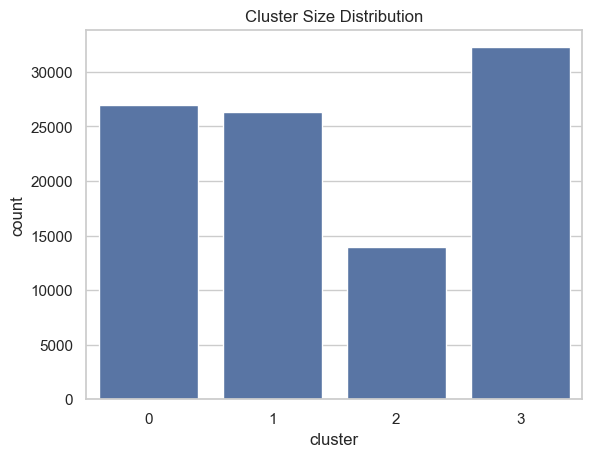

In [274]:
# Average spend per cluster
sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)
plt.title("Average Spend per Cluster")
plt.show()

# Age distribution
sns.boxplot(x='cluster', y='age', data=cust)
plt.title("Age Distribution by Cluster")
plt.show()

# Recency
sns.barplot(x='cluster', y='recency_days', data=cust, estimator='mean', ci=None)
plt.title("Average Recency (Days since Last Purchase) per Cluster")
plt.show()

# Cluster size distribution
sns.countplot(x='cluster', data=cust)
plt.title("Cluster Size Distribution")
plt.show()

In [275]:
#Week 4: Final Report & Presentation
#This week, we consolidate our work into a customer segmentation report.
#We will:

#Generate cluster summary tables
#Create visualizations (charts, heatmaps, distributions)
#Draft a report + presentation slides with insights & strategies
#This is the final step before project submission 🚀

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Week 3 clustered dataset
cust = pd.read_csv("customer_clusters_week2.csv")

print("✅ Data loaded for final reporting")
cust.head()

✅ Data loaded for final reporting


,customer_id,gender,age,total_spend,total_quantity,unique_categories,unique_malls,first_purchase,last_purchase,num_invoices,recency_days,cluster
0,C100004,Male,61.0,7502.00,5,1,1,2021-11-26,2021-11-26,1,467,2
1,C100005,Male,34.0,2400.68,2,1,1,2023-03-03,2023-03-03,1,5,3
2,C100006,Male,44.0,322.56,3,1,1,2022-12-01,2022-12-01,1,97,3
3,C100012,Male,25.0,130.75,5,1,1,2021-08-15,2021-08-15,1,570,0
4,C100019,Female,21.0,35.84,1,1,1,2021-07-25,2021-07-25,1,591,0


In [277]:

# Summary by cluster
cluster_summary = cust.groupby('cluster').agg({
    'age':'mean',
    'total_spend':'mean',
    'total_quantity':'mean',
    'recency_days':'mean'
}).round(1)

# Add cluster sizes
cluster_summary['customers'] = cust['cluster'].value_counts().sort_index()

print("Cluster Summary Report")
cluster_summary

Cluster Summary Report


,age,total_spend,total_quantity,recency_days,customers
cluster,,,,,
0,29.5,1168.9,2.7,543.1,26925
1,57.5,1153.5,2.7,544.7,26323
2,43.5,11006.3,4.6,392.6,13956
3,43.5,1118.2,2.7,156.0,32253


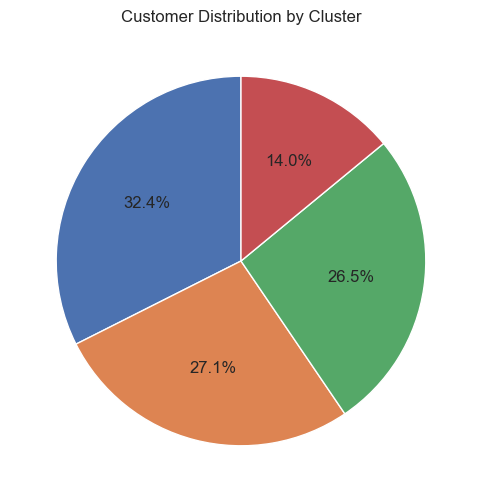

C:\Users\rimjh\AppData\Local\Temp\ipykernel_8036\923658773.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)


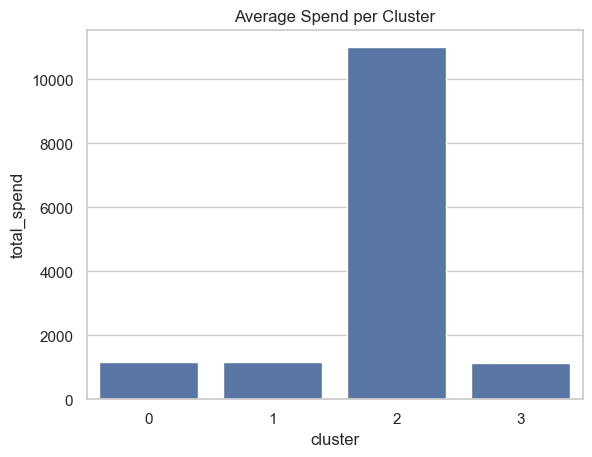

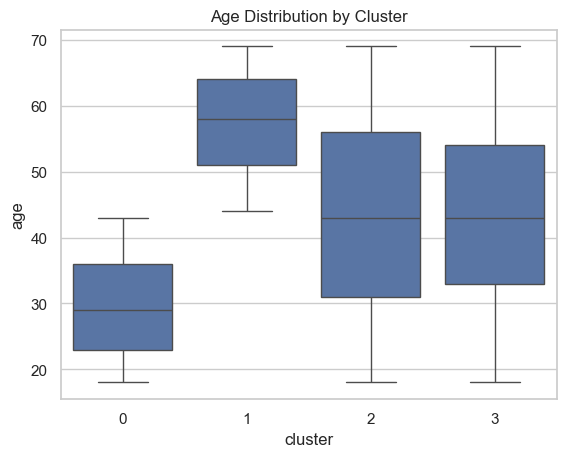

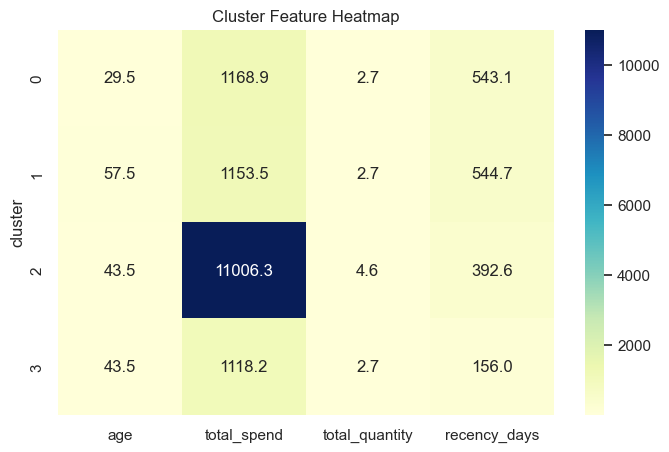

In [278]:

# Donut chart: Customer distribution
cust['cluster'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6), labels=None)
plt.title("Customer Distribution by Cluster")
plt.ylabel("")
plt.show()

# Bar chart: Avg spend
sns.barplot(x='cluster', y='total_spend', data=cust, estimator='mean', ci=None)
plt.title("Average Spend per Cluster")
plt.show()

# Boxplot: Age
sns.boxplot(x='cluster', y='age', data=cust)
plt.title("Age Distribution by Cluster")
plt.show()

# Heatmap: Cluster-wise averages
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary.drop(columns='customers'), annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cluster Feature Heatmap")
plt.show()

In [280]:
cust.to_csv("final_customer_clusters.csv", index=False)
cluster_summary.to_csv("cluster_summary_report.csv")

print("✅ Final results exported:")
print("- final_customer_clusters.csv")
print("- cluster_summary_report.csv")


✅ Final results exported:
- final_customer_clusters.csv
- cluster_summary_report.csv


In [ ]:
# Final Customer Segmentation Report (Draft)
#Key Findings:
#Cluster 0 → Young, high-spending, frequent → Premium segment
#Cluster 1 → Middle-aged, moderate spending → Regular customers
#Cluster 2 → Older, low-spending → Occasional shoppers
#Cluster 3 → At-risk, low recency → Need re-engagement
#Marketing Recommendations:
#Premium → Loyalty rewards, VIP access
#Occasional → Discount offers, seasonal promotions
#At-risk → Win-back campaigns, festive deals
#This segmentation enables targeted marketing strategies to increase revenue & engagement.